In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-1_w504rm
  Running command git clone -q https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-1_w504rm
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-ffh0gelp/fasterzip_8625622b002f48848383b2cc2f4cc308
  Running command git clone -q https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-ffh0gelp/fasterzip_8625622b002f48848383b2cc2f4cc308
  Created wheel for pyafmreader: filename=pyafmreader-x.x.x-py3-none-any.whl size=26227 sha256=ee2f2b454f3a9d86e2ea51336568afcfa721d0708c36ae8fa6ff9c41e35c6b62
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-hqclrkal/whe

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-ukqby_6c
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-ukqby_6c
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=30918 sha256=35cbab5a200b1bb0f6bc973bab204748da766efad47b98ea07e0a0dd592921ab
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-djj9i46d/wheels/45/a3/5e/2d19803e3cbf5fe45f904090127b31ec30fc304c6b6e5e0f70
Successfully built pyafmrheo
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel

In [6]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Datasets/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [7]:
file = loadfile(file_path)

In [8]:
filemetadata = file.filemetadata
print(filemetadata['file_type'])

.jpk-force-map


In [9]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [10]:
curve_idx = 4
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

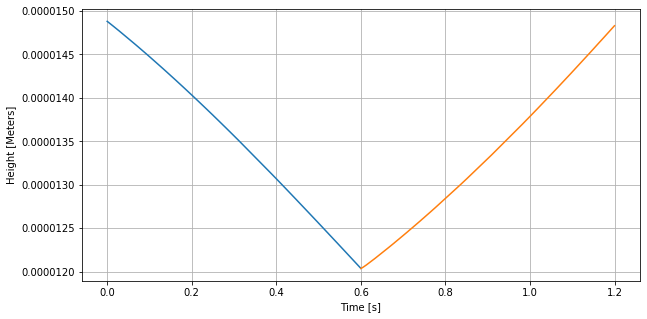

In [11]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

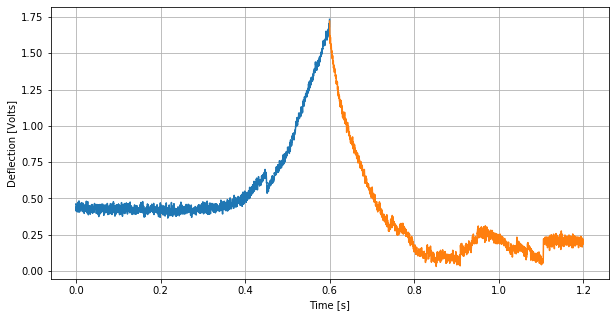

In [12]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

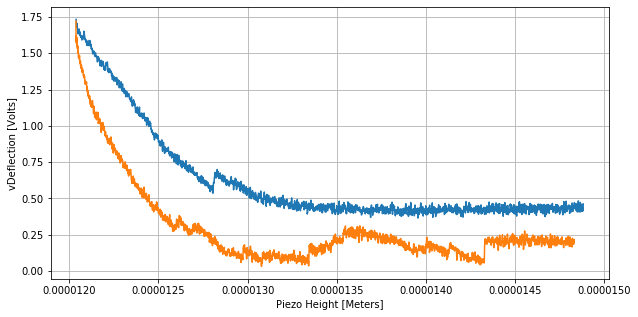

In [13]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [14]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
first_ext_seg.preprocess_segment(deflection_sensitivity, height_channel)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
last_ret_seg.preprocess_segment(deflection_sensitivity, height_channel)

In [15]:
# Shift height
xzero = last_ret_seg.zheight[-1] # Maximum height
first_ext_seg.zheight = xzero - first_ext_seg.zheight
last_ret_seg.zheight = xzero - last_ret_seg.zheight

In [16]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [26]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, 350e-9)
print(*poc)

1.9863043443120347e-06 8.880422653553056e-09


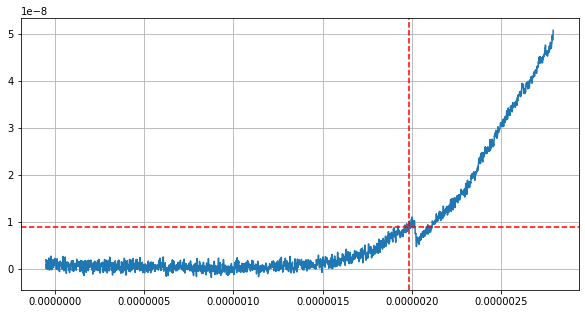

In [27]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

In [31]:
app_deflection = correct_tilt(app_height, app_deflection, poc[0])
plt.plot(app_height, app_deflection)

TypeError: expected non-empty vector for x

1314.6646376452518

        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        BEC Model: None

        Number of free parameters: 3

        delta0: -4.119954989977096e-08

        E0: 1271.37601040406

        f0: 2.2518039729988954e-11

        slope: None

        # Fit metrics
        MAE: 3.5595579785353713e-19

        MSE: 9.05261850116326e-22

        RMSE: 3.008756969441577e-11

        Rsq: 0.9359267965113207

        Chisq: 2.608792249560172e-07

        RedChisq: 8.695974165200573e-08

        


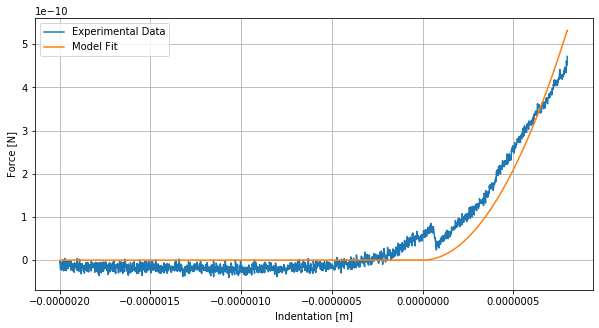

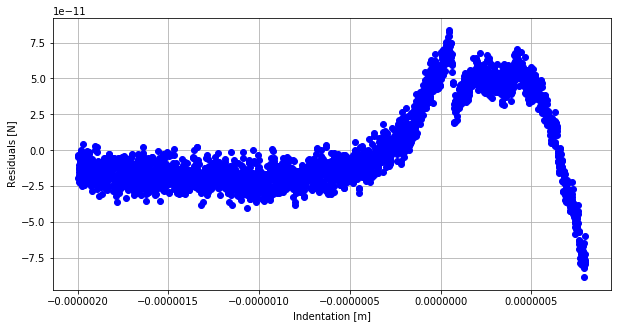

In [28]:
# Hertz fit
poc[1] = 0
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)
print(hertzmodel.E0_init)

hertzmodel.fit_report()

hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

702.0878872912406

        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        BEC Model: None

        Number of free parameters: 4

        delta0: -9.442797575309414e-08

        E0: 558.5509102348886

        f0: 1.528790529035602e-11

        slope: 8.41466764609258e-06

        # Fit metrics
        MAE: 2.7169708265312544e-20

        MSE: 1.380580737200824e-22

        RMSE: 1.1749811646153414e-11

        Rsq: 0.990228437164799

        Chisq: 1.6315447866293124e-08

        RedChisq: 4.078861966573281e-09

        


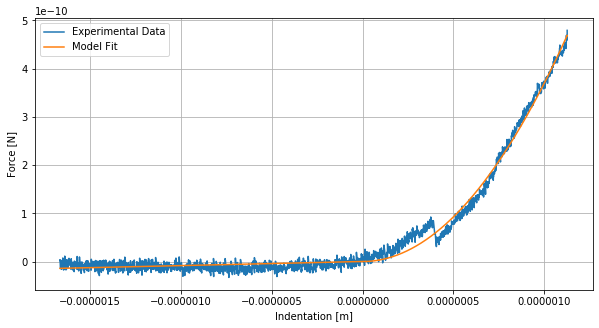

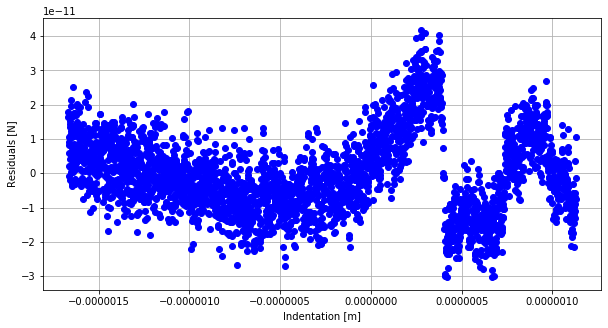

In [23]:
# Hertz fit
poc[1] = 0
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit_hline_flag = True
hertzmodel.fit(app_indentation, app_force)
print(hertzmodel.E0_init)

hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

hertzmodel.fit_report()

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()